# Example of running the particle_tracking class and its associated functions for Single Particle Tracking

This notebook provides an example for using the particle_tracking class. It is implemented on .nd2 microscopy images which were acquired using the JOBS module in NIS elements (Nikon / LIM). Every channel (e.g., Phase contrast, GFP etc) is save in a separate .nd2 file, and the stream acquisition of the particle fluorescence is also saved separately. The cells were segmented using a Unet (see Mäkelä, Papagiannakis *et al*,  https://doi.org/10.7554/eLife.97465.3) which stored the cell labels in .tif images. The particle_tracking class has been adapted to work with the respective data formats. 

Author: Alexandros Papagiannakis, HHMI at Stanford University, 2025

## Generate file paths

The code below can be used to generate the file paths that will be used as variables to initialize the particle_tracking class. These file paths are specific to the JOBS protocols applied to automate image and stream acquisition. 

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), "/particle_tracking_UNET_for_GitHub.py"))
import particle_tracking_UNET_for_GitHub as spt_gh

save_path = '.../test_data_466'
images_path = '.../20210613_203659_466'
masks_path = '.../20210613_203659_466_tif'
stream_channel = 'FITC'
phase_channel = 'Trans'
signal_channel = 'mCherry'
interval = 50
images_names = os.listdir(images_path)
masks_names = os.listdir(masks_path)
positions = list(range(0,50))
experiment = '20210613_203659_466'

position = 0
# This script iterates over the JOBS particle tracking output, and the Unet labeled masks
if position <= 9:
    position_string = 'Point000'+str(position)
elif position > 9:
    position_string = 'Point00'+str(position) # the JOBS xy positions are defined as Point
# get the matching Unet path
matching = [s for s in masks_names if position_string in s]
matching = [s for s in matching if 'mask' in s][0]
unet_path = masks_path + '/' + matching
# get the matching stream images and snapshots
matching = [s for s in images_names if position_string in s]
fast_time_lapse_path = images_path + '/' + matching[0] 
snapshots_paths = [images_path + '/' + matching[2], images_path + '/' + matching[3], images_path + '/' + matching[1]]

## Class initialization
The image paths above, together with the experiment and CY position IDs will be used to initialize the class and store it in a variable called "particle"

In [2]:
particle = spt_gh.particle_tracking(unet_path, snapshots_paths, fast_time_lapse_path, experiment, position, interval, save_path) #initialize the particle tracking class





t
<FramesSequenceND>
Axes: 3
Axis 'x' size: 2048
Axis 'y' size: 2048
Axis 't' size: 300
Pixel Datatype: <class 'numpy.uint16'>
81 cells in total


## Check cell segmentation
The Unet cell segmentation will be checked. This step is also important to confirm that the Unet masks have been successfully incorporated in the class to match the phase contrast image. 

printing the cell boundaries on the phase contrast image...


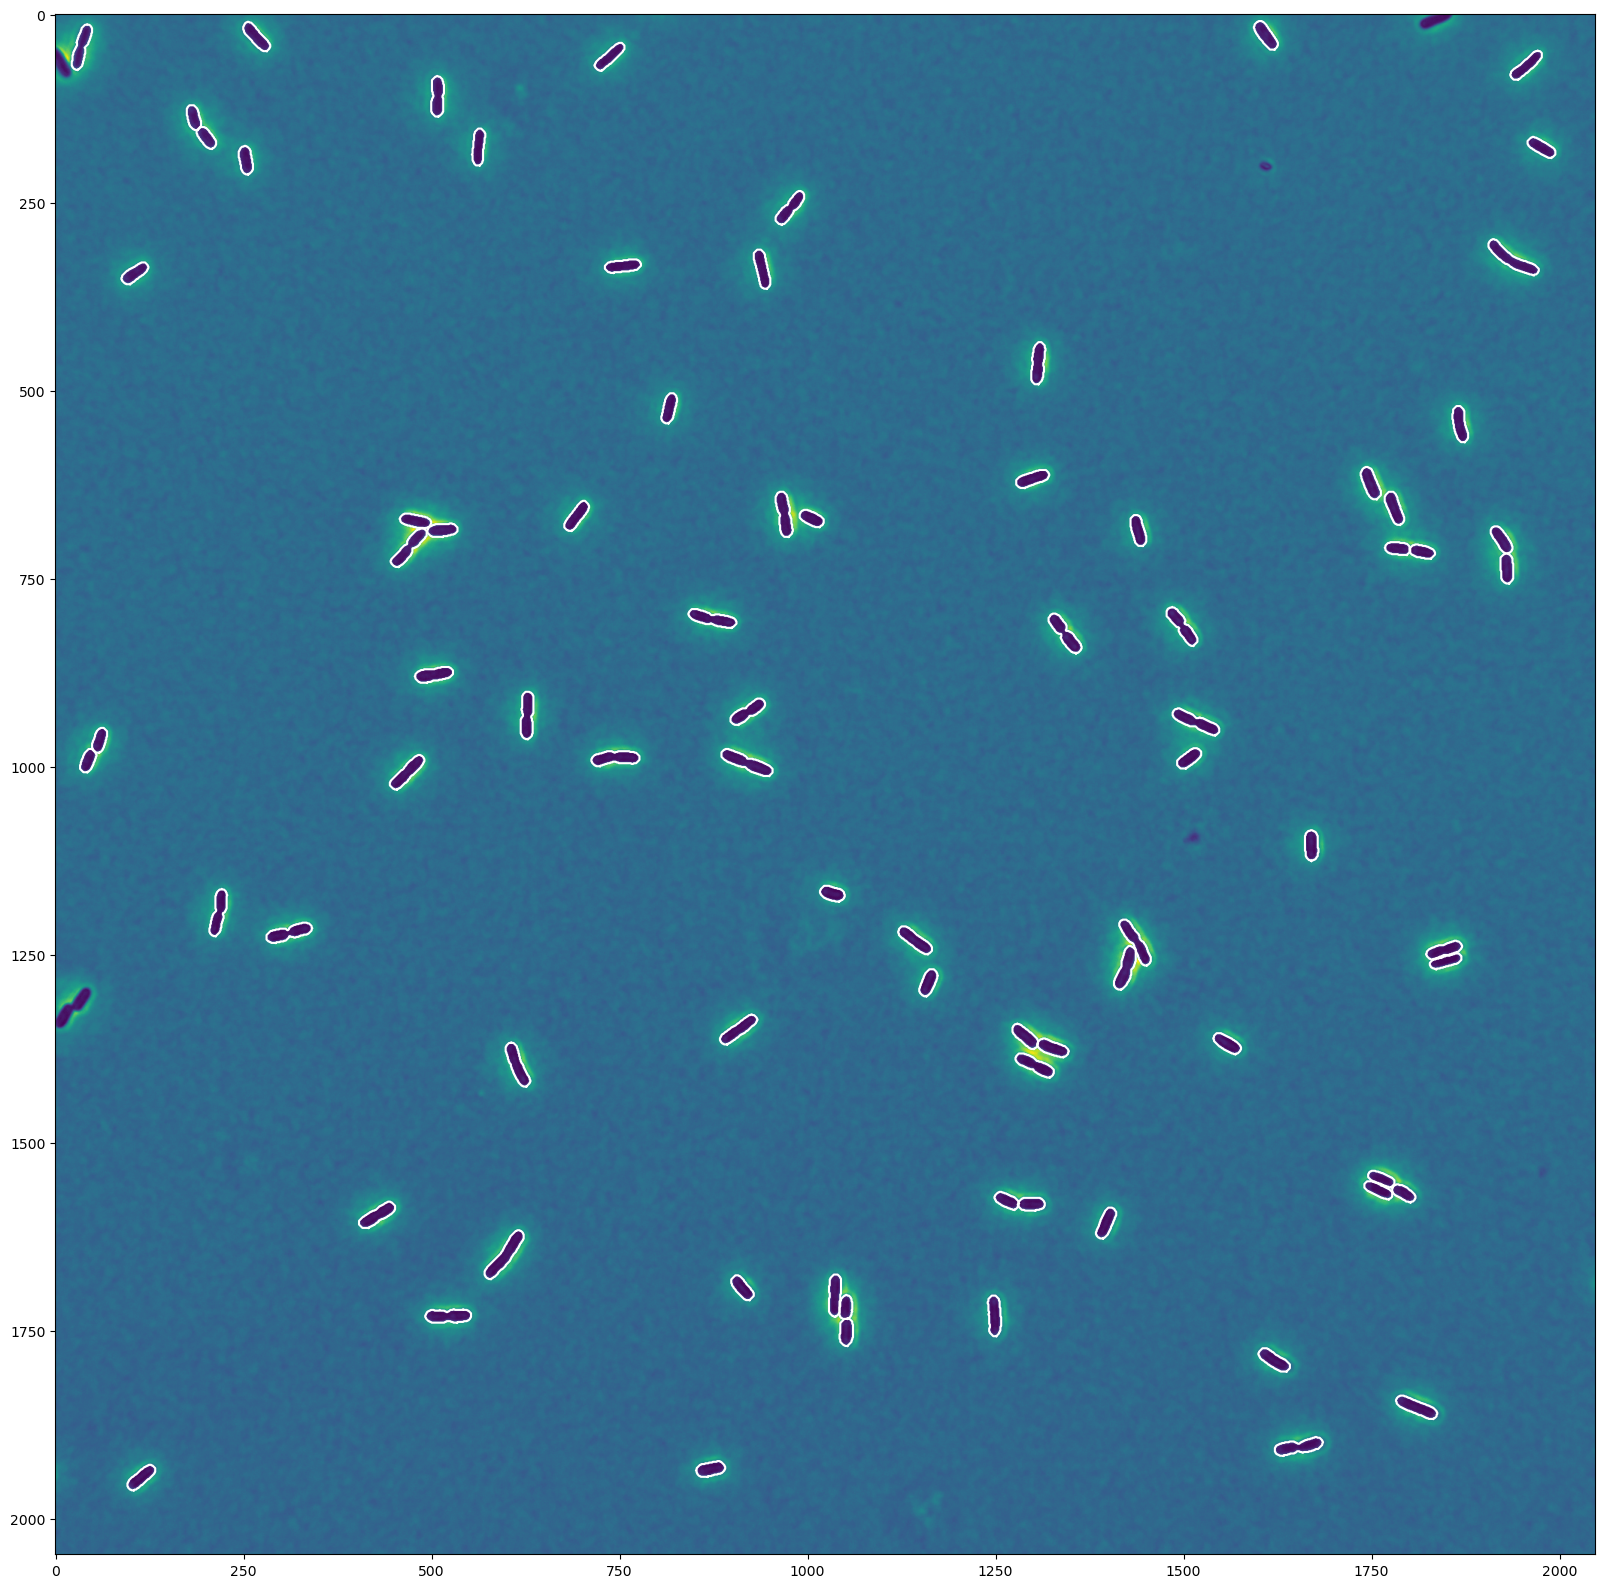

In [3]:
particle.show_unet_masks() # visualize the cell segmentation

## Test the particle segmentation parameters
This interactive function can be used to test the particle segmentation parameters.

In [4]:
# particle.test_segmentation_parameters(10, post_process=True)
# The input() function that is used here does not work in some Jupyter notebooks.
# This function should work in any other full-Python kernel.

## Segment the particles
The particle segmentation method is applied for 100 frames (since this is a test) using the following parameters:
1. log_adaptive_parameters=[4, 1000, 99, 2, 9, -6, 0]
2. min_particle_size=3
3. max_particle_size=60
4. min_particle_aspect_ratio=0.3
5. post_processing_threshold=90
6. box_size=7

In [6]:
particle_df = particle.getting_the_particles(channel_offset=(0,0), log_adaptive_parameters=[4, 1000, 99, 2, 9, -6, 0], 
                                      min_particle_size=3, max_particle_size=60, min_particle_aspect_ratio=0.3,
                                      post_processing_threshold=90, box_size=7, analysis_range=(0,particle.n_frames-200), 
                                      metric='raw pixels', operation='sum',  gaussian_fit_show = False) # particle segmentation

frame 1 out of 300, position: XY01
Subtracting background...
Filtering image...
(1854.0, 0.0) 3.0 3.265986323710904 0.0 Error: division by zero, spot aborted
(1600.0, 16.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(10.0, 68.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(565.0, 181.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(1930.0, 324.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(1780.0, 645.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(463.0, 669.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(452.0, 728.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(1358.0, 840.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(510.0, 881.5) 2.0 2.0 0.0 Error: division by zero, spot aborted
(478.0, 991.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(1830.0, 1250.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(1557.0, 1367.0) 1.0 0.0 0.0 Error: division by zero, spot aborted
(429.5, 1591.0) 2.0 2.0 0.0 Error: division by zero, spot

In [7]:
particle_df.columns.tolist()

['experiment',
 'xy_position',
 'cell',
 'frame',
 'particle_center',
 'max_fluorescence',
 'particle_brightest_pixels',
 'smoothed_brightest_pixels',
 'gaussian_center',
 'gaussian_amplitude',
 'gaussian_std',
 'gaussian_volume',
 'gaussian_rotation',
 'particle_fluorescence',
 'average_background_fluorescence']

## Particle tracking
The stored particle_df Pandas DataFrame will be used to track the particles. Merged trajectories will be removed, the trajectories that have a length less than 1.7% of the total stream acquisition length in frames will also be removed, and non-overlapping trajectories that belong to the same cell will be merged to reconstruct maximum length trajectories. 

particle index: 0 , in frame: 0 , linked to particle index: 64 , in frame: 1
particle index: 1 , in frame: 0 , linked to particle index: 65 , in frame: 1
particle index: 2 , in frame: 0 , linked to particle index: 66 , in frame: 1
particle index: 3 , in frame: 0 , linked to particle index: 67 , in frame: 1
particle index: 4 , in frame: 0 , linked to particle index: 68 , in frame: 1
particle index: 5 , in frame: 0 , linked to particle index: 69 , in frame: 1
particle index: 6 , in frame: 0 , linked to particle index: 71 , in frame: 1
particle index: 7 , in frame: 0 , linked to particle index: 73 , in frame: 1
particle index: 8 , in frame: 0 , linked to particle index: 74 , in frame: 1
particle index: 9 , in frame: 0 , linked to particle index: 75 , in frame: 1
particle index: 10 , in frame: 0 , was not linked to a particle
particle index: 11 , in frame: 0 , linked to particle index: 76 , in frame: 1
particle index: 12 , in frame: 0 , was not linked to a particle
particle index: 13 , in 

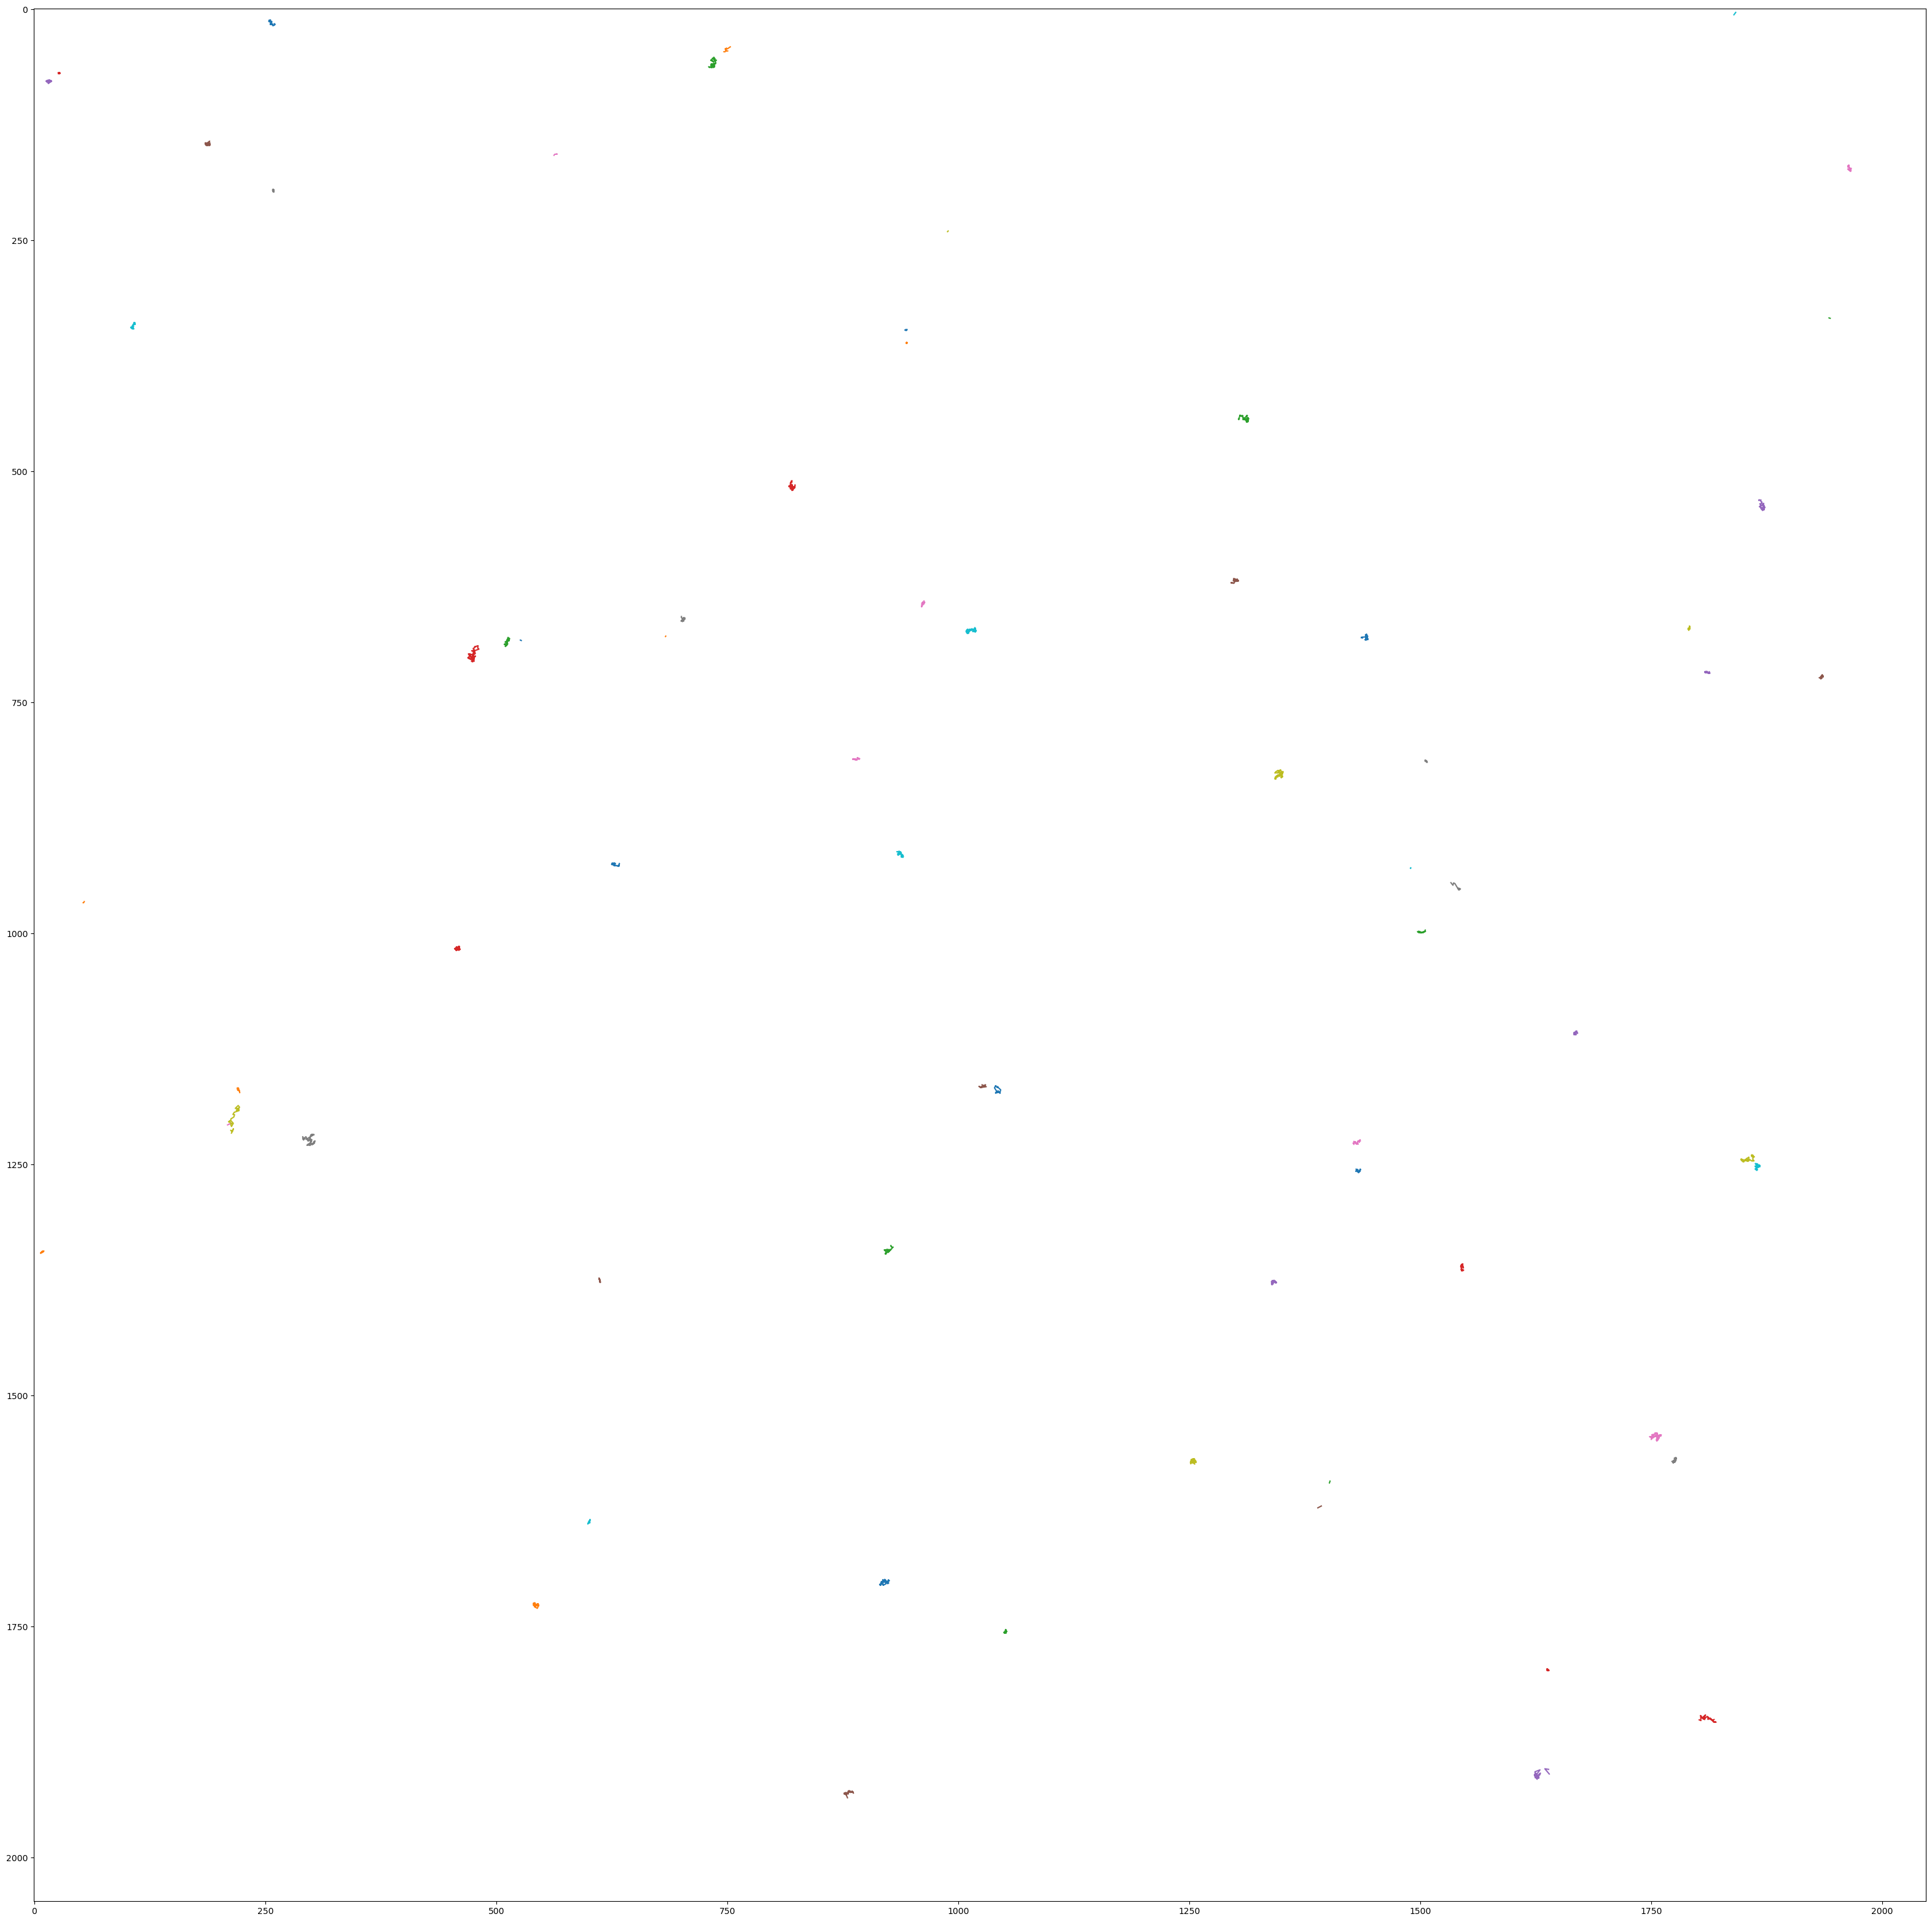

removing trajectories with duplicated frames...


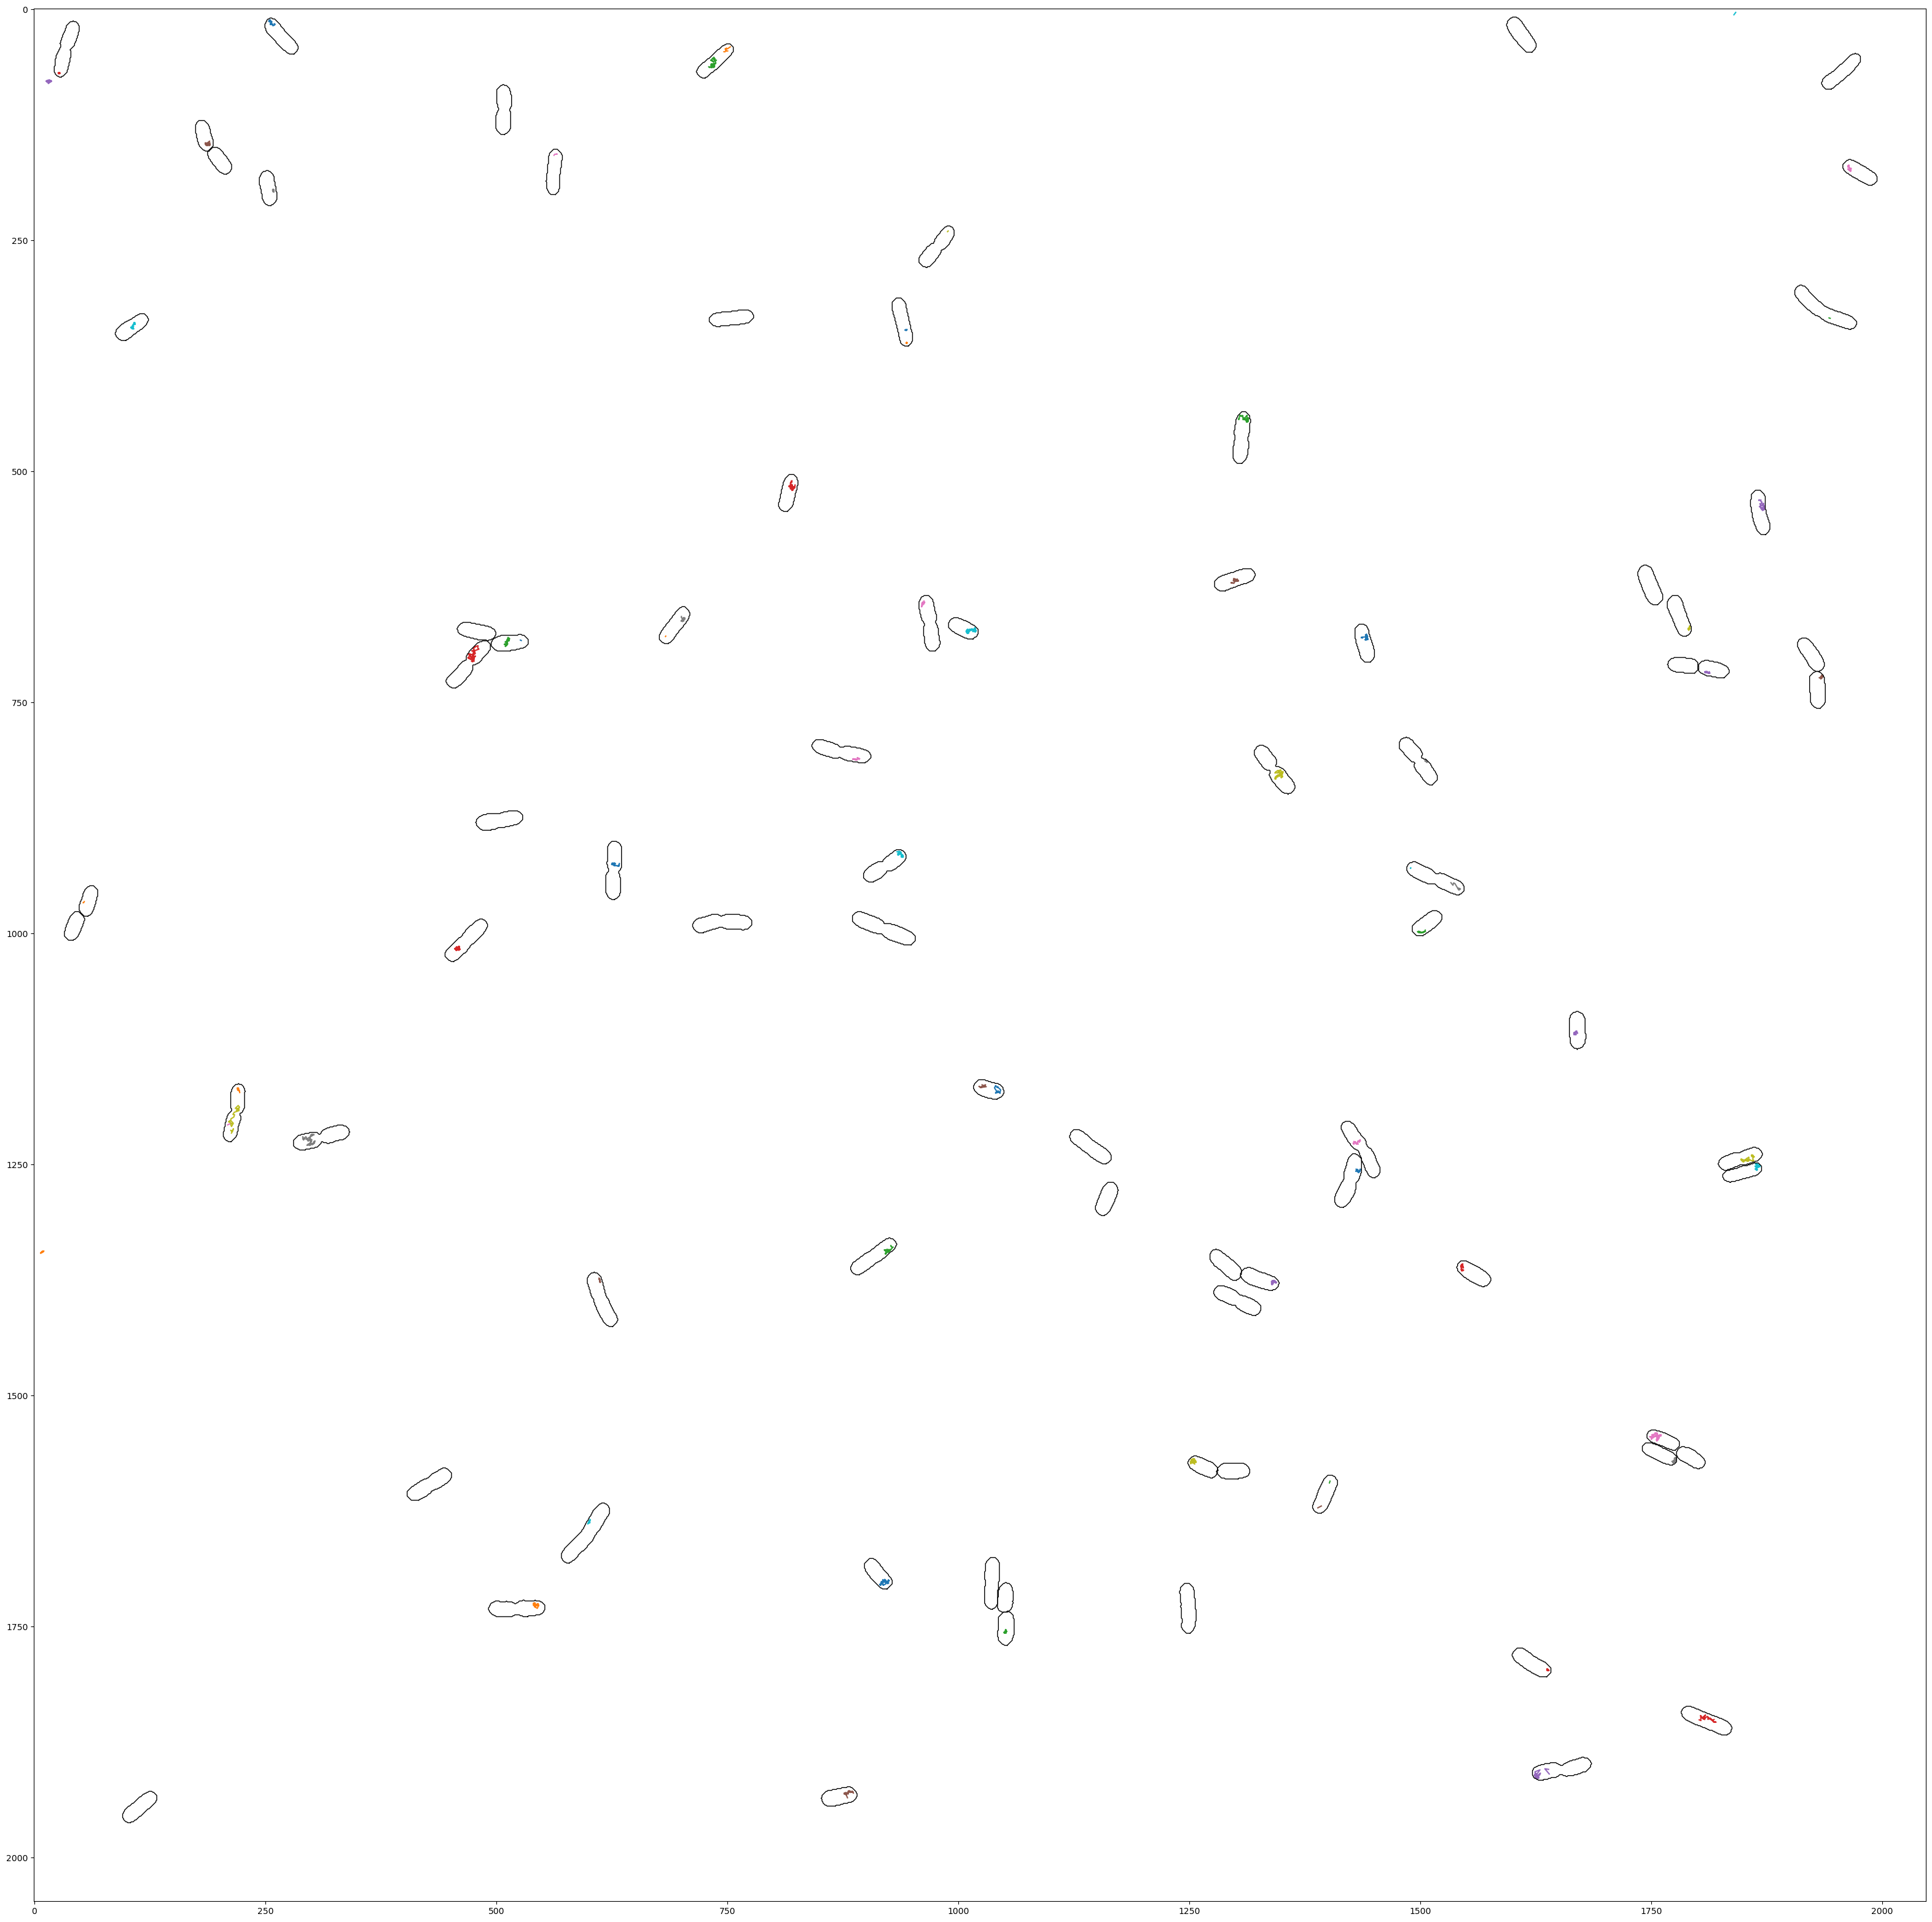

In [5]:
particle_tracking_df = particle.run_particle_tracking(max_radius=8, memory=3, fluorescence_bandpass=(0.2,5), fraction_length=0.017, merged=True, cell_connect=True) # particle tracking